# Image augmentaion:

this notebook helps your to augment your annotations.
    1. Rotate (0 - 360)
    2. Add sharpness (random)
    3. Add brightness (random)

In [12]:
from time import sleep
from utils import *

# Directory in which images exists 
DIR_PATH = "/media/sohaib/additional_/DataScience/Upwork_orders/people_walk_in_zebra_crossing/Mask---RCNN-Polygons-/data/zebra_crossing_and_footprints/"

# Json File Path
doc_labels = "/media/sohaib/additional_/DataScience/Upwork_orders/people_walk_in_zebra_crossing/Mask---RCNN-Polygons-/data/zebra_crossing_and_footprints/annotation1.json"

# Rotation angle degree (Rotate image at angle)
degrees = 360

# Parsing Json
images = parse_via_json(doc_labels, DIR_PATH)

# Getting all of the classes from your annotations 
classes = list(set([ __ for _ in images.values() for __ in list(_.keys())]))
print(classes)

# Images you are going to augment should be greater than 1
if len(images) <= 1:
    print("I need at least 2 images")
    exit()

# Spliting train and testing images
total_training = int(len(images) * 0.9)
counter = 0

# Initilzing Train and val multiprocessing augmentation class
train = Augmentation(DIR_PATH + "/train/", degrees)
val = Augmentation(DIR_PATH + "/val/", degrees)


# Creating images
print("Creating Images....")
for image_path in images:
    if  counter < total_training:

        train.run(image_path, images[image_path])
    else:
        val.run(image_path, images[image_path])
    counter += 1


while train.pending > 0 or val.pending > 0:
    print(f"Train Pending  :{train.pending},  Validation Pending: {val.pending}", end= '\r')
    
    sleep(1)





print("Saving Labels into json")
save_mrcnn_labels(train.augmented_images, DIR_PATH + "/train/via_region_data.json", classes)
save_mrcnn_labels(val.augmented_images, DIR_PATH + "/val/via_region_data.json", classes)
file1 = open(DIR_PATH+"labels.txt","w")
write='"' + '","'.join(classes) + '"'
file1.writelines(write)
file1.close()


['zebra_crossing', 'feet']
Creating Images....
Cannot find labels for /media/sohaib/additional_/DataScience/Upwork_orders/people_walk_in_zebra_crossing/Mask---RCNN-Polygons-/data/zebra_crossing_and_footprints/-in-front-of-children-with-backpacks-walking-through-crosswalk-to-the-school.jpg
Cannot find labels for /media/sohaib/additional_/DataScience/Upwork_orders/people_walk_in_zebra_crossing/Mask---RCNN-Polygons-/data/zebra_crossing_and_footprints/-pedestrian-crossing-street-photography-4e61c7dc-ea14-478a-a3e1-52f6321b8943.jpg
Cannot find labels for /media/sohaib/additional_/DataScience/Upwork_orders/people_walk_in_zebra_crossing/Mask---RCNN-Polygons-/data/zebra_crossing_and_footprints/-walking-crowded-businessman-businesswoman-crosswalk-illustration_229548-231.jpg
Cannot find labels for /media/sohaib/additional_/DataScience/Upwork_orders/people_walk_in_zebra_crossing/Mask---RCNN-Polygons-/data/zebra_crossing_and_footprints/00pedxing01-superJumbo.jpg
Cannot find labels for /media/sohai

Cannot find labels for /media/sohaib/additional_/DataScience/Upwork_orders/people_walk_in_zebra_crossing/Mask---RCNN-Polygons-/data/zebra_crossing_and_footprints/PEOPLE-CROSSWALK-.jpg
Cannot find labels for /media/sohaib/additional_/DataScience/Upwork_orders/people_walk_in_zebra_crossing/Mask---RCNN-Polygons-/data/zebra_crossing_and_footprints/person-walk-walking-crosswalk-thumbnail.jpg
Cannot find labels for /media/sohaib/additional_/DataScience/Upwork_orders/people_walk_in_zebra_crossing/Mask---RCNN-Polygons-/data/zebra_crossing_and_footprints/2Fmethode2Fsundaytimes2Fprod2Fweb2Fbin2Faeab1902-f88f-11e7-af66-6e848ca65d7a.jpg
Cannot find labels for /media/sohaib/additional_/DataScience/Upwork_orders/people_walk_in_zebra_crossing/Mask---RCNN-Polygons-/data/zebra_crossing_and_footprints/3D-ZC-2.jpg
Cannot find labels for /media/sohaib/additional_/DataScience/Upwork_orders/people_walk_in_zebra_crossing/Mask---RCNN-Polygons-/data/zebra_crossing_and_footprints/1200px-Crosswalk_of_Market_at_T

# Validation of Augmentation

Validating Images are augmentated right or not

/media/sohaib/additional_/DataScience/Upwork_orders/people_walk_in_zebra_crossing/Mask---RCNN-Polygons-/data/zebra_crossing_and_footprints/train/abbeyroadfans*.*g
['/media/sohaib/additional_/DataScience/Upwork_orders/people_walk_in_zebra_crossing/Mask---RCNN-Polygons-/data/zebra_crossing_and_footprints/train/_101823025_abbeyroadfans.jpg-4091276-0-1.0.jpg']


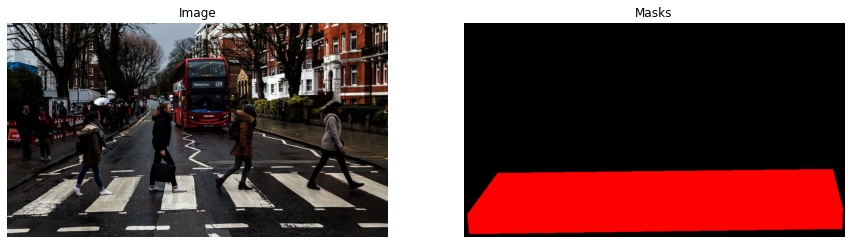

In [22]:


import random

# Path of augmented train path
base_path = f'{doc_labels.rsplit("/",1)[0]}/train/'
json_file_path = f"{base_path}/via_region_data.json"
labels = json.load(open(json_file_path))

# Getting all of the images
print(base_path + "abbeyroadfans*.*g")
images = glob.glob(base_path + "*abbeyroadfans*.*g")
print(images)

# Getting the random sample from the images
image_list = random.sample(images,1)


# Getting x and y and ploting the images
for image_name in image_list:
    object_name = image_name.rsplit("/",1)[1].rsplit(".",1)[0]
    img = Image.open(f'{image_name}')

    points = []
    for i in range(len(labels[f'{object_name}.json']['regions'])):
        x = labels[f'{object_name}.json']['regions'][i]['shape_attributes']['all_points_x']
        y = labels[f'{object_name}.json']['regions'][i]['shape_attributes']['all_points_y']

        points.append(list(zip(x,y)))
    
    mask = make_mask(points,img.size)
    
    display([img , mask])

